<a href="https://colab.research.google.com/github/micheleavella/GT_project/blob/michele/progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import os
from IPython.display import clear_output

In [12]:
def pay(box,drone):
    if np.any(drone > 4) or np.any(drone < 0) : return 0    #0 if it goes out of the map
    return 100/(1+np.sum((drone+box)**2))                   #inv prop to the distance^2

def map(DIM,box,drone):
    fig = plt.figure(figsize = (6,6))
    plt.plot(box[0],box[1],'o',color='red')
    plt.plot(drone[0],drone[1],'x',color='blue')
    plt.xlim([0, DIM])
    plt.ylim([0, DIM])

def step_test(pay,DIM,box,drone,dir):
    # 0 UP - 1 RIGHT - 2 DOWN - 3 LEFT

    d = np.copy(drone)
    if dir == 0:    d[1]+=1
    elif dir == 1:  d[0]+=1
    elif dir == 2:  d[1]-=1
    else:           d[0]-=1

    print(d)
    print(pay(box,d))
    return pay(box,d)

## Multiple drones with multiple boxes
drones $i$, bokes $k$.
$$
u_i(\{\vec x_j\},\{\vec b_k\}) = (\langle \frac{100}{1+d^2(\vec x_i,\vec b_j)}\rangle_j - \langle \frac{100\cdot \gamma}{1+d^2(\vec x_i,\vec x_j)} \rangle_j)\cdot \prod_j (1-\delta(\vec x_i -\vec x_j))
$$
Where $d^2(,)$ is the square distance. $\gamma$ is a real positive parameter that controls how much drones want to stay distant from each other.

IDEA
We can also use the gaussian distance.

In [31]:
class GAME:
    def __init__(self, DIM, n_d, n_b):
        self.DIM = DIM
        self.n_d = n_d
        self.n_b = n_b
        self.drones = [Drone(self.DIM) for i in range (n_d)]
        self.boxes = [Box(self.DIM) for i in range (n_b)]
        self.mov = [np.array([0,1]),np.array([1,0]),np.array([0,-1]),np.array([-1,0])]
        self.hist = []
        self.hist_b = np.copy(self.boxes)
        for i in range(n_d): self.hist.append([np.copy(self.drones[i].x)])

    
    #compute payoff for player x given position of other players (X) and other boxes (B)
    def u_i(self,x,X,B):
        if any(np.all(x == i) for i in X): return -1000         #crash
        if np.any(x<0) or np.any(x>=self.DIM): return -1000     #ouside map
        D = [100/(1+np.sum((x-b)**2)) for b in B]               #sum of distances from boxes
        R = [50/(1+np.sum((x-b)**2)) for b in X]                #sum of distances from drones

        return np.mean(D)-np.mean(R)

    #decide where to go using GT and NE
    def step(self):
        #matrix of positions
        D = np.array([d.x for d in self.drones])
        
        A = [0, 1, 2, 3]
        temp = list(product(A, repeat = len(D)-1))
        ris = []

        #for each player
        for i in range(len(D)):
            app = []

            #for each action of all the players but i
            for j in temp:
                X = np.copy(D)                  # other players
                X = np.delete(X,i,axis=0)        
                for o in range(len(X)):
                    X[o] += self.mov[j[o]]           #move all but i
                u = []
                s = []
                for m in A:
                    x = np.copy(D[i])           # player i
                    x += self.mov[m]            # move player i
                    s.append([m,j])
                    u.append(self.u_i(x,X,[b.x for b in self.boxes]))
                # chose best response
                indxs = np.argwhere(u == np.max(u)).flatten()
                #print(j,u)
                # buld sets of actions
                for ind in indxs: 
                    y = s[ind][0]
                    z = list(s[ind][1])
                    z.insert(i,y)
                    app.append(tuple(z))
            ris.append(set(app))
        #out are the nash-eqs
        out = list(set.intersection(*ris))
        ris = out[np.random.randint(len(out))]          #now I'm chosing a random NE but I should chose the best one (NON SON SICURO)
        
        for d in range(len(self.drones)):   
            self.drones[d].moves(ris[d])
            self.hist[d].append(np.copy(self.drones[d].x))
            

    def hit_box(self):
        for d in self.drones:
            for j in range(len(self.boxes)):
                if np.all(d.x == self.boxes[j].x): 
                    self.boxes.pop(j)
                    clear_output(wait=True)
                    print('Boxes left: ',len(self.boxes))
                    break

    #play the game
    def play(self):
        CONT = 0
        n_b = len(self.boxes)
        while self.boxes:
            CONT += 1
            self.step() #make a step
            self.hit_box()
        clear_output(wait=True)
        print('DONE :)')
        return(CONT)
            


class Drone:
    def __init__(self, DIM):
        self.x = np.random.randint(0,DIM,2)
        #self.x = np.array([10,10])
        self.mov = [np.array([0,1]),np.array([1,0]),np.array([0,-1]),np.array([-1,0])]
    def moves(self,i):
        self.x += self.mov[i]

class Box:
    def __init__(self, DIM):
        self.x = np.random.randint(0,DIM,2)

In [34]:
np.random.seed(12345)
g = GAME(100,4,40)
g.boxes
%time g.play()

DONE :)
CPU times: user 1min 4s, sys: 1.07 s, total: 1min 5s
Wall time: 1min 4s


308

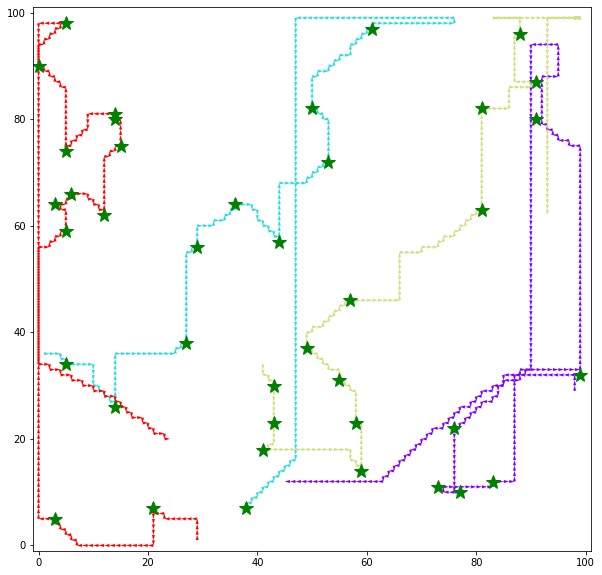

In [35]:
from matplotlib.pyplot import cm


DIM = g.DIM
fig = plt.figure(figsize = (10,10))
color = cm.rainbow(np.linspace(0, 1, len(g.hist)))

for H,C in zip(g.hist,color):
    d1 = np.array(H)
    x = d1[:,0]
    y = d1[:,1]
    plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,width=0.004 , color = C)


for b in g.hist_b: 
    plt.plot(b.x[0],b.x[1],'*',color='green',markersize=15)


plt.xlim([-1, DIM+1])
plt.ylim([-1, DIM+1])

plt.savefig('map.png', dpi=180)